In [2]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from scipy.stats import skew


import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read the CSV files

case_data = pd.read_csv('5yrs_Case_Data.csv')
control_data = pd.read_csv('5yrs_Control_Data.csv')

In [4]:
# Check the number of unique PATID values in each DataFrame

print("Number of unique PATID values in case_data:", case_data['PATID'].nunique())
print("Number of unique PATID values in control_data:", control_data['PATID'].nunique())

Number of unique PATID values in case_data: 4012
Number of unique PATID values in control_data: 119723


In [1]:
# Concatenate the two datasets along the rows

data = pd.concat([case_data, control_data], ignore_index=True)

# Print the combined DataFrame info to verify the changes
print(data.info())
print(data.head())

In [8]:
# Find the number of missing values per column

data.isnull().sum(axis=0)
print(data.isnull().sum(axis=0))

PATID               0
Sex                 0
Race                7
Marital_Status     14
Max_DBP            79
Max_SBP            55
Min_DBP            79
Min_SBP            55
Comorbidities     813
Smoking_Status    445
Encounter Type      0
Age_Grp             0
Target              0
dtype: int64


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123735 entries, 0 to 123734
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PATID           123735 non-null  int64  
 1   Sex             123735 non-null  object 
 2   Race            123728 non-null  object 
 3   Marital_Status  123721 non-null  object 
 4   Max_DBP         123656 non-null  float64
 5   Max_SBP         123680 non-null  float64
 6   Min_DBP         123656 non-null  float64
 7   Min_SBP         123680 non-null  float64
 8   Comorbidities   122922 non-null  object 
 9   Smoking_Status  123290 non-null  object 
 10  Encounter Type  123735 non-null  object 
 11  Age_Grp         123735 non-null  object 
 12  Target          123735 non-null  int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 12.3+ MB


In [10]:
# Check the number of missing values in each column
missing_values_after_imputation = data.isnull().sum()

# Calculate the percentage of missing values in each column
percentage_missing = (missing_values_after_imputation / len(data)) * 100

# Print the number of missing values and their percentage
missing_data_summary = pd.DataFrame({
    'Missing Values': missing_values_after_imputation,
    'Percentage Missing': percentage_missing
})


print(missing_data_summary)

                Missing Values  Percentage Missing
PATID                        0            0.000000
Sex                          0            0.000000
Race                         7            0.005657
Marital_Status              14            0.011315
Max_DBP                     79            0.063846
Max_SBP                     55            0.044450
Min_DBP                     79            0.063846
Min_SBP                     55            0.044450
Comorbidities              813            0.657049
Smoking_Status             445            0.359640
Encounter Type               0            0.000000
Age_Grp                      0            0.000000
Target                       0            0.000000


# Check for Symmetry and skewness to decide whether to use the mean, median or mode for imputing missing values in numerical data

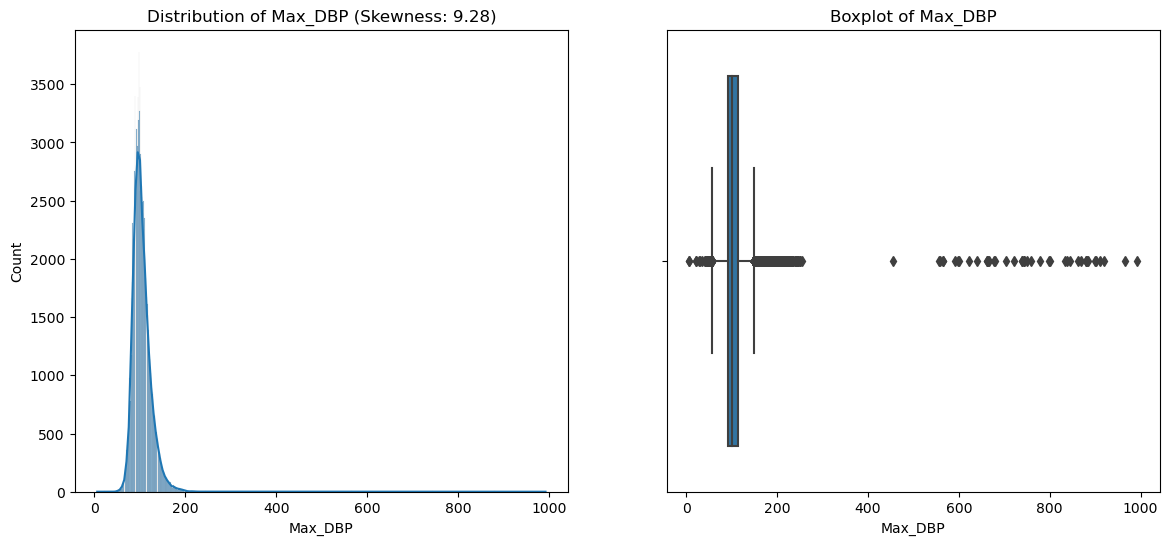

Max_DBP: Distribution is skewed or has outliers. Impute missing values with median.


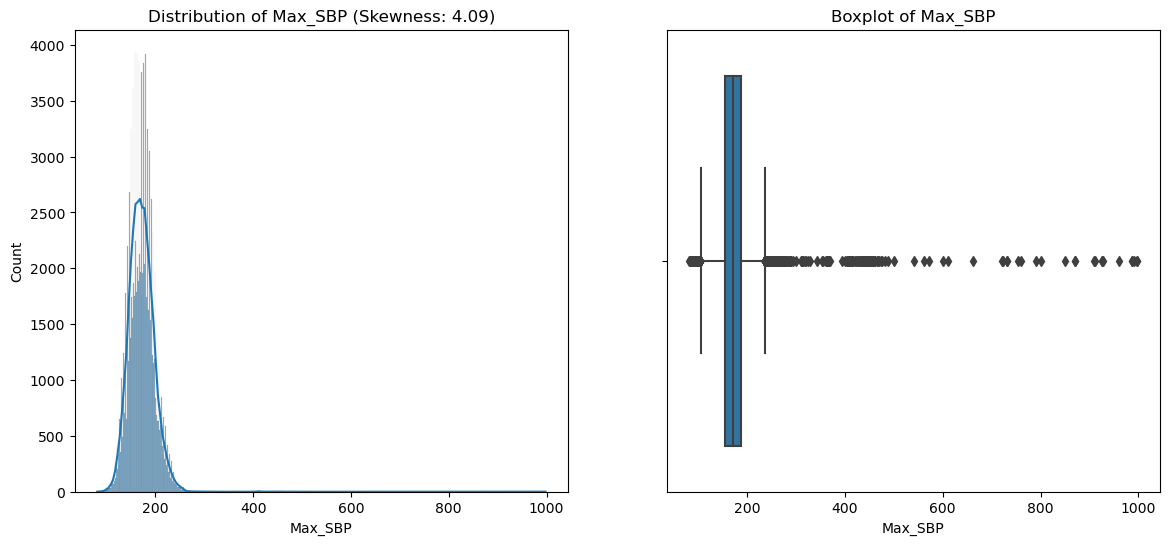

Max_SBP: Distribution is skewed or has outliers. Impute missing values with median.


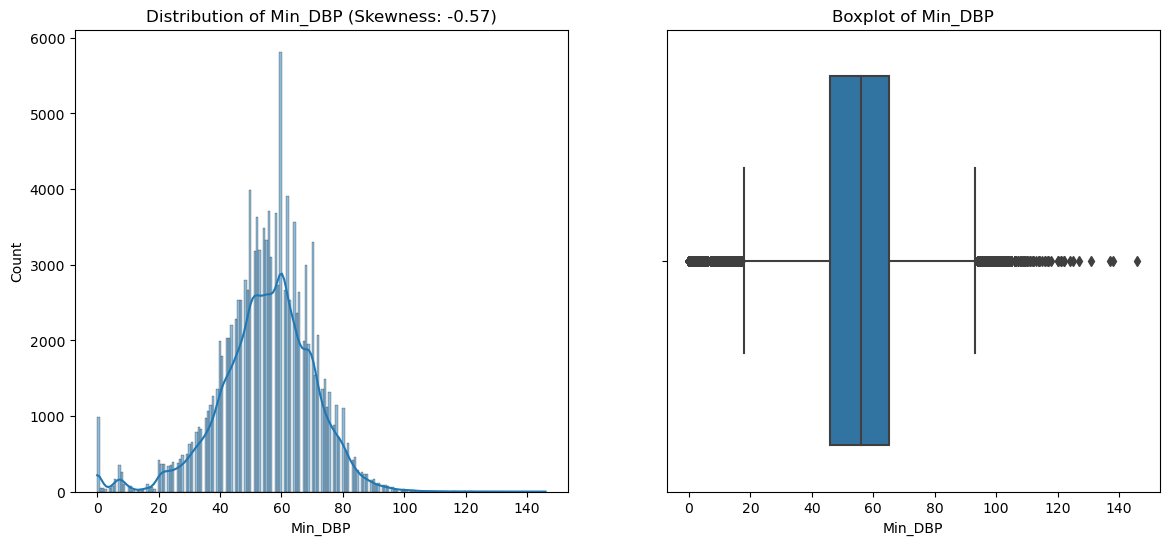

Min_DBP: Distribution is skewed or has outliers. Impute missing values with median.


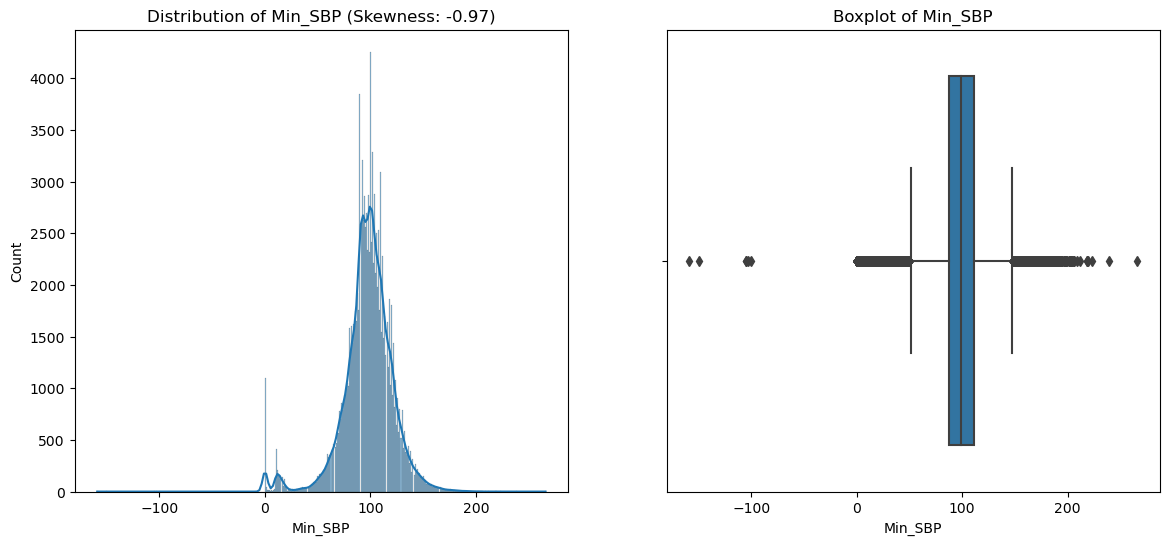

Min_SBP: Distribution is skewed or has outliers. Impute missing values with median.


In [11]:

# Define the numerical columns
numerical_columns = ['Max_DBP', 'Max_SBP', 'Min_DBP', 'Min_SBP']

for column in numerical_columns:
    # Calculate the column skewness
    column_skewness = skew(data[column].dropna())
    
    # Plot the distribution and a boxplot
    plt.figure(figsize=(14, 6))
    
    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data[column].dropna(), kde=True)
    plt.title(f'Distribution of {column} (Skewness: {column_skewness:.2f})')
    
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[column])
    plt.title(f'Boxplot of {column}')
    
    # Save the plot
    plt.savefig(f'{column}_distribution_boxplot.png')
    
    
    plt.show()

    # Choose mean or median.
    if abs(column_skewness) < 0.5:
        print(f"{column}: Distribution is fairly symmetric. Impute missing values with mean.")
    else:
        print(f"{column}: Distribution is skewed or has outliers. Impute missing values with median.")


# Impute missing values for the numerical features

In [12]:
# Impute missing values with median for skewed distributions or columns with outliers

data['Max_DBP'].fillna(data['Max_DBP'].median(), inplace=True)
data['Max_SBP'].fillna(data['Max_SBP'].median(), inplace=True)
data['Min_SBP'].fillna(data['Min_SBP'].median(), inplace=True)
data['Min_DBP'].fillna(data['Min_DBP'].median(), inplace=True)

In [13]:
# Check the number of missing values in each column

missing_values_after_imputation = data.isnull().sum()
missing_values_after_imputation

PATID               0
Sex                 0
Race                7
Marital_Status     14
Max_DBP             0
Max_SBP             0
Min_DBP             0
Min_SBP             0
Comorbidities     813
Smoking_Status    445
Encounter Type      0
Age_Grp             0
Target              0
dtype: int64

# Mapping and Encoding Diastolic Blood Pressure (DBP), and Systolic Blood Pressure (SBP)

In [14]:
# Create SBP and DBP categories with desired labels
data['SBP_Category'] = pd.cut(data['Max_SBP'], bins=[-float('inf'), 120, 140, float('inf')], labels=['SBP <=120', 'SBP 120-140', 'SBP >=140'])
data['DBP_Category'] = pd.cut(data['Max_DBP'], bins=[-float('inf'), 80, 90, float('inf')], labels=['DBP <=80', 'DBP 80-90', 'DBP >=90'])

# Perform one-hot encoding with the correct names
data = pd.get_dummies(data, columns=['SBP_Category', 'DBP_Category'])

# Rename the columns to match the format
data = data.rename(columns={
    'SBP_Category_SBP <=120': 'SBP below 120',
    'SBP_Category_SBP 120-140': 'SBP 120-140',
    'SBP_Category_SBP >=140': 'SBP above 140',
    'DBP_Category_DBP <=80': 'DBP below 80',
    'DBP_Category_DBP 80-90': 'DBP 80-90',
    'DBP_Category_DBP >=90': 'DBP above 90'
})

# Remove the original columns
data = data.drop(columns=['Max_SBP', 'Min_SBP', 'Max_DBP', 'Min_DBP'])

# Display the result
print(data.head())

# Check and print the count for each category
print("Count for each SBP category:")
print(f"SBP below 120: {data['SBP below 120'].sum()}")
print(f"SBP 120-140: {data['SBP 120-140'].sum()}")
print(f"SBP above 140: {data['SBP above 140'].sum()}")

print("\nCount for each DBP category:")
print(f"DBP below 80: {data['DBP below 80'].sum()}")
print(f"DBP 80-90: {data['DBP 80-90'].sum()}")
print(f"DBP above 90: {data['DBP above 90'].sum()}")


     PATID Sex   Race Marital_Status  \
0  1701255   M  WHITE        Married   
1  1713714   F  WHITE        Widowed   
2   680917   F  WHITE         Single   
3  1719957   M  WHITE        Married   
4  2665014   F  WHITE        Widowed   

                                       Comorbidities  \
0  Anxiety disorder, unspecified-F41.9,Major depr...   
1  Hyperlipidemia, unspecified-E78.5,Headache-R51...   
2  ANXIETY STATE NOS,Essential (primary) hyperten...   
3                                                NaN   
4                                                NaN   

                             Smoking_Status                  Encounter Type  \
0  Former smoker quit longer than 12 months  OUTPATIENT,EMERGENCY,INPATIENT   
1  Former smoker quit longer than 12 months                      OUTPATIENT   
2                              Never smoker  OUTPATIENT,EMERGENCY,INPATIENT   
3  Former smoker quit longer than 12 months                      OUTPATIENT   
4                          

In [15]:
# Check the number of missing values in each column
missing_values = data.isnull().sum()

# Calculate the percentage of missing values in each column
percentage_missing = (missing_values / len(data)) * 100

# Print the number of missing values and their percentage
missing_data_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage Missing': percentage_missing
})


print(missing_data_summary)


                Missing Values  Percentage Missing
PATID                        0            0.000000
Sex                          0            0.000000
Race                         7            0.005657
Marital_Status              14            0.011315
Comorbidities              813            0.657049
Smoking_Status             445            0.359640
Encounter Type               0            0.000000
Age_Grp                      0            0.000000
Target                       0            0.000000
SBP below 120                0            0.000000
SBP 120-140                  0            0.000000
SBP above 140                0            0.000000
DBP below 80                 0            0.000000
DBP 80-90                    0            0.000000
DBP above 90                 0            0.000000


# Mapping and Encoding

# 1. Encoding 'Age' column

In [16]:
# One hot encoding on the 'Age_Grp' column
age_group_dummies = pd.get_dummies(data['Age_Grp'], prefix='Age_Grp')

# Concatenate the original DataFrame with the new one hot encoded columns
data = pd.concat([data, age_group_dummies], axis=1)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123735 entries, 0 to 123734
Data columns (total 20 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   PATID           123735 non-null  int64 
 1   Sex             123735 non-null  object
 2   Race            123728 non-null  object
 3   Marital_Status  123721 non-null  object
 4   Comorbidities   122922 non-null  object
 5   Smoking_Status  123290 non-null  object
 6   Encounter Type  123735 non-null  object
 7   Age_Grp         123735 non-null  object
 8   Target          123735 non-null  int64 
 9   SBP below 120   123735 non-null  uint8 
 10  SBP 120-140     123735 non-null  uint8 
 11  SBP above 140   123735 non-null  uint8 
 12  DBP below 80    123735 non-null  uint8 
 13  DBP 80-90       123735 non-null  uint8 
 14  DBP above 90    123735 non-null  uint8 
 15  Age_Grp_50-60   123735 non-null  uint8 
 16  Age_Grp_60-70   123735 non-null  uint8 
 17  Age_Grp_70-80   123735 non-nu

# Descriptive Statistics of 'Age Group'

        Count  Percentage
50-60    3533    2.855296
60-70   36773   29.719158
70-80   39804   32.168748
80-90   28540   23.065422
90-100  15085   12.191377


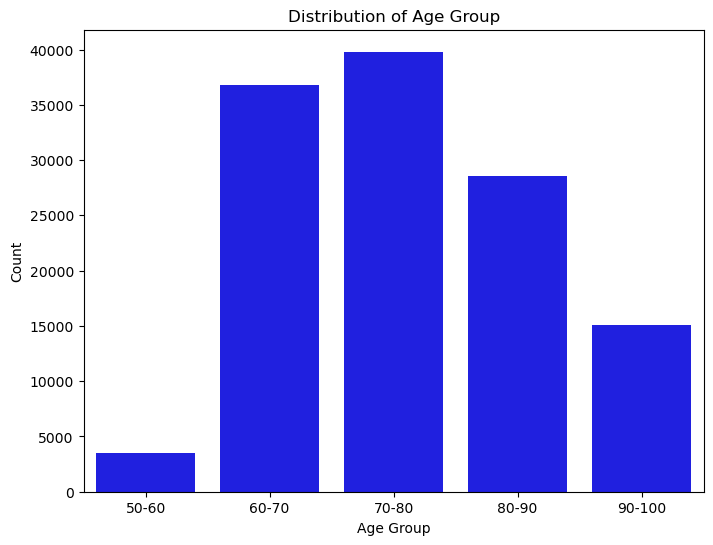

In [30]:
# Count of each age group
age_group_counts = data['Age_Grp'].value_counts().sort_index()

# Percentage of each age group
age_group_percentages = data['Age_Grp'].value_counts(normalize=True).sort_index() * 100

# Create a DataFrame to display counts and percentages together
age_group_stats = pd.DataFrame({'Count': age_group_counts,'Percentage': age_group_percentages})

# Display the descriptive statistics
print(age_group_stats)

# Visualization for Age Group
plt.figure(figsize=(8, 6))
sns.countplot(x='Age_Grp', data=data, color=  'blue', order=sorted(data['Age_Grp'].unique()))
plt.title('Distribution of Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')

# Save the plot
plt.savefig('age_group_distribution.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# Drop the original 'Age_Group' column
data = data.drop(columns=['Age_Grp'])

# Display the DataFrame
print(data.head())
data.info()

     PATID Sex   Race Marital_Status  Max_DBP  Max_SBP  Min_DBP  Min_SBP  \
0  1701255   M  WHITE        Married     97.0    178.0     57.0     94.0   
1  1713714   F  WHITE        Widowed    108.0    180.0     65.0    105.0   
2   680917   F  WHITE         Single    119.0    194.0     33.0     68.0   
3  1719957   M  WHITE        Married     96.0    158.0     62.0    106.0   
4  2665014   F  WHITE        Widowed     89.0    186.0     42.0    110.0   

                                       Comorbidities  \
0  Anxiety disorder, unspecified-F41.9,Major depr...   
1  Hyperlipidemia, unspecified-E78.5,Headache-R51...   
2  ANXIETY STATE NOS,Essential (primary) hyperten...   
3                                                NaN   
4                                                NaN   

                             Smoking_Status                  Encounter Type  \
0  Former smoker quit longer than 12 months  OUTPATIENT,EMERGENCY,INPATIENT   
1  Former smoker quit longer than 12 months     

# 2. Imputation, Mapping and Encoding for 'Smoking_Status' column 

In [13]:
# Print initial count of Smoking_Status

initial_count = data['Smoking_Status'].value_counts(dropna=False)
print("Initial value counts for 'Smoking_Status' column:")
print(initial_count)

Initial value counts for 'Smoking_Status' column:
Never smoker                                51837
Former smoker quit longer than 12 months    36157
Current every day smoker                    31363
Current some day smoker                      1979
Former smoker quit within 12 months          1478
NaN                                           445
Light tobacco smoker                          293
Heavy tobacco smoker                          121
Smoker ###                                     62
Name: Smoking_Status, dtype: int64


In [14]:
# Impute missing values (with most frequent value) in the 'Smoking_Status' column

data['Smoking_Status'].fillna(data['Smoking_Status'].mode()[0], inplace=True)

# Verify the changes after imputation

print("\nValue counts for 'Smoking_Status' column after imputation:")
print(data['Smoking_Status'].value_counts(dropna=False))


Value counts for 'Smoking_Status' column after imputation:
Never smoker                                52282
Former smoker quit longer than 12 months    36157
Current every day smoker                    31363
Current some day smoker                      1979
Former smoker quit within 12 months          1478
Light tobacco smoker                          293
Heavy tobacco smoker                          121
Smoker ###                                     62
Name: Smoking_Status, dtype: int64


# Define the Mapping Function of Smoking_Status

In [15]:
# First Normalize and clean the string values in 'Smoking_Status'

data['Smoking_Status'] = data['Smoking_Status'].str.replace('#', '').str.strip()

In [16]:
# Verify the changes 

print("\nValue counts for 'Smoking_Status' column:")
print(data['Smoking_Status'].value_counts(dropna=False))


Value counts for 'Smoking_Status' column:
Never smoker                                52282
Former smoker quit longer than 12 months    36157
Current every day smoker                    31363
Current some day smoker                      1979
Former smoker quit within 12 months          1478
Light tobacco smoker                          293
Heavy tobacco smoker                          121
Smoker                                         62
Name: Smoking_Status, dtype: int64


In [18]:
# Define the mapping for encoding

smoking_status_mapping = {
    'Never smoker': 0,
    'Former smoker quit longer than 12 months': 1,
    'Former smoker quit within 12 months': 1,
    'Light tobacco smoker': 1,
    'Current some day smoker': 1,
    'Current every day smoker': 1,
    'Smoker': 1,
    'Heavy tobacco smoker': 1
}

In [19]:
data['Smoking_Status'] = data['Smoking_Status'].map(smoking_status_mapping)

print(data)

          PATID Sex   Race Marital_Status  Max_DBP  Max_SBP  Min_DBP  Min_SBP  \
0       1701255   M  WHITE        Married     97.0    178.0     57.0     94.0   
1       1713714   F  WHITE        Widowed    108.0    180.0     65.0    105.0   
2        680917   F  WHITE         Single    119.0    194.0     33.0     68.0   
3       1719957   M  WHITE        Married     96.0    158.0     62.0    106.0   
4       2665014   F  WHITE        Widowed     89.0    186.0     42.0    110.0   
...         ...  ..    ...            ...      ...      ...      ...      ...   
123730  2633300   F  WHITE       Divorced    105.0    177.0     41.0     89.0   
123731  1575030   F  WHITE        Married     98.0    160.0     78.0    127.0   
123732  2940185   M  WHITE        Married     92.0    169.0     61.0     99.0   
123733  1210750   M  WHITE         Single    145.0    236.0     34.0     62.0   
123734  2430126   M  WHITE        Married    136.0    165.0     53.0     11.0   

                           

In [20]:
# Check the counts of each category after encoding

encoded_counts = data['Smoking_Status'].value_counts()

print(encoded_counts)

1    71453
0    52282
Name: Smoking_Status, dtype: int64


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123735 entries, 0 to 123734
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PATID           123735 non-null  int64  
 1   Sex             123735 non-null  object 
 2   Race            123728 non-null  object 
 3   Marital_Status  123721 non-null  object 
 4   Max_DBP         123656 non-null  float64
 5   Max_SBP         123680 non-null  float64
 6   Min_DBP         123656 non-null  float64
 7   Min_SBP         123680 non-null  float64
 8   Comorbidities   122922 non-null  object 
 9   Smoking_Status  123735 non-null  int64  
 10  Encounter Type  123735 non-null  object 
 11  Target          123735 non-null  int64  
 12  Age_Grp_50-60   123735 non-null  uint8  
 13  Age_Grp_60-70   123735 non-null  uint8  
 14  Age_Grp_70-80   123735 non-null  uint8  
 15  Age_Grp_80-90   123735 non-null  uint8  
 16  Age_Grp_90-100  123735 non-null  uint8  
dtypes: float64

# 3. Mapping and Encoding 'Sex' column

In [22]:
# List unique 'Sex' values

unique_Sex_Status = data['Sex'].unique()
print(unique_Sex_Status)

# Verify the unique values
print(data[['Sex']].head())
print(data['Sex'].value_counts(dropna=False)) 

['M' 'F']
  Sex
0   M
1   F
2   F
3   M
4   F
F    66487
M    57248
Name: Sex, dtype: int64


In [23]:
# Apply one-hot encoding to the 'Sex' column

data = pd.get_dummies(data, columns=['Sex'], dummy_na=False)

In [24]:
# Verify the info of the one-hot encoded DataFrame

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123735 entries, 0 to 123734
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PATID           123735 non-null  int64  
 1   Race            123728 non-null  object 
 2   Marital_Status  123721 non-null  object 
 3   Max_DBP         123656 non-null  float64
 4   Max_SBP         123680 non-null  float64
 5   Min_DBP         123656 non-null  float64
 6   Min_SBP         123680 non-null  float64
 7   Comorbidities   122922 non-null  object 
 8   Smoking_Status  123735 non-null  int64  
 9   Encounter Type  123735 non-null  object 
 10  Target          123735 non-null  int64  
 11  Age_Grp_50-60   123735 non-null  uint8  
 12  Age_Grp_60-70   123735 non-null  uint8  
 13  Age_Grp_70-80   123735 non-null  uint8  
 14  Age_Grp_80-90   123735 non-null  uint8  
 15  Age_Grp_90-100  123735 non-null  uint8  
 16  Sex_F           123735 non-null  uint8  
 17  Sex_M     

In [133]:
# Check the counts of each category after encoding
encoded_counts = data['Sex_F'].value_counts()
encoded_counts = data['Sex_M'].value_counts()

print(encoded_counts)

0    66487
1    57248
Name: Sex_M, dtype: int64


# 4. Imputation, Mapping and Encoding for 'Race' column

In [135]:
# Check unique values in the 'Race' column

print(data['Race'].value_counts(dropna=False)) 

WHITE                                      113346
BLACK OR AFRICAN AMERICAN                    7458
SOME OTHER RACE                              1127
ASIAN                                        1077
Unknown                                       460
AMERICAN INDIAN OR ALASKAN NATIVE             211
NATIVE HAWAIIAN OR OTHER PACIFIC ISLAND        49
NaN                                             7
Name: Race, dtype: int64


In [136]:
# Replace 'Unknown' with NaN
data['Race'] = data['Race'].replace('Unknown', np.nan)

# Verify the changes
print("Value counts for 'Race' column after replacing 'Unknown' with NaN:")
print(data['Race'].value_counts(dropna=False))

Value counts for 'Race' column after replacing 'Unknown' with NaN:
WHITE                                      113346
BLACK OR AFRICAN AMERICAN                    7458
SOME OTHER RACE                              1127
ASIAN                                        1077
NaN                                           467
AMERICAN INDIAN OR ALASKAN NATIVE             211
NATIVE HAWAIIAN OR OTHER PACIFIC ISLAND        49
Name: Race, dtype: int64


In [137]:
# Check the number of missing values in each column
missing_values = data.isnull().sum()

# Calculate the percentage of missing values in each column
percentage_missing = (missing_values / len(data)) * 100

# Print the number of missing values and their percentage
missing_data_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage Missing': percentage_missing
})

print(missing_data_summary)

                Missing Values  Percentage Missing
PATID                        0            0.000000
Race                       467            0.377419
Marital_Status              14            0.011315
Comorbidities              813            0.657049
Smoking_Status               0            0.000000
Encounter Type               0            0.000000
Target                       0            0.000000
SBP below 120                0            0.000000
SBP 120-140                  0            0.000000
SBP above 140                0            0.000000
DBP below 80                 0            0.000000
DBP 80-90                    0            0.000000
DBP above 90                 0            0.000000
Age_Grp_50-60                0            0.000000
Age_Grp_60-70                0            0.000000
Age_Grp_70-80                0            0.000000
Age_Grp_80-90                0            0.000000
Age_Grp_90-100               0            0.000000
Sex_F                        0 

In [138]:
# Check the number of missing values in each column
missing_values = data.isnull().sum()
print(missing_values)

PATID               0
Race              467
Marital_Status     14
Comorbidities     813
Smoking_Status      0
Encounter Type      0
Target              0
SBP below 120       0
SBP 120-140         0
SBP above 140       0
DBP below 80        0
DBP 80-90           0
DBP above 90        0
Age_Grp_50-60       0
Age_Grp_60-70       0
Age_Grp_70-80       0
Age_Grp_80-90       0
Age_Grp_90-100      0
Sex_F               0
Sex_M               0
dtype: int64


In [139]:
# Impute missing values (with most frequent value) in the 'Race' column

data['Race'].fillna(data['Race'].mode()[0], inplace=True)  

# Verify the changes after imputation
print("\nValue counts for 'Race' column after imputation:")
print(data['Race'].value_counts(dropna=False))


Value counts for 'Race' column after imputation:
WHITE                                      113813
BLACK OR AFRICAN AMERICAN                    7458
SOME OTHER RACE                              1127
ASIAN                                        1077
AMERICAN INDIAN OR ALASKAN NATIVE             211
NATIVE HAWAIIAN OR OTHER PACIFIC ISLAND        49
Name: Race, dtype: int64


# Define the Mapping Function for 'Race'

In [140]:
# Normalize and clean the string and Define the mapping function for 'Race'
# Treat any other unknown or unexpected values as Unknown

def map_race(status):
    status = status.lower().strip() 
    
    if status in ['white', 
                  'black or african american', 
                  'some other race',
                  'asian', 
                  'american indian or alaskan native', 
                  'native hawaiian or other pacific island']:
        return status
    else:
        return 'unknown'  


data['Race_Grouped'] = data['Race'].apply(map_race)

print(data['Race_Grouped'].value_counts(dropna=False))

# One-hot encoding on the 'Race_Grouped' column
data = pd.get_dummies(data, columns=['Race_Grouped'], prefix='Race')

white                                      113813
black or african american                    7458
some other race                              1127
asian                                        1077
american indian or alaskan native             211
native hawaiian or other pacific island        49
Name: Race_Grouped, dtype: int64


In [141]:
# Check the unique values and their counts in the 'Race' column after mapping

race_counts = data.filter(like='Race_').sum()
print(race_counts)

# Display the dataframe to verify encoding
print(data.head())


Race_american indian or alaskan native             211
Race_asian                                        1077
Race_black or african american                    7458
Race_native hawaiian or other pacific island        49
Race_some other race                              1127
Race_white                                      113813
dtype: int64
     PATID   Race Marital_Status  \
0  1701255  WHITE        Married   
1  1713714  WHITE        Widowed   
2   680917  WHITE         Single   
3  1719957  WHITE        Married   
4  2665014  WHITE        Widowed   

                                       Comorbidities  Smoking_Status  \
0  Anxiety disorder, unspecified-F41.9,Major depr...               1   
1  Hyperlipidemia, unspecified-E78.5,Headache-R51...               1   
2  ANXIETY STATE NOS,Essential (primary) hyperten...               0   
3                                                NaN               1   
4                                                NaN               0   

       

In [142]:
# Dictionary mapping old column names to new column names

new_column_names = {
    'Race_american indian or alaskan native': 'AMERICAN_IND/ALASKAN',
    'ace_asian': 'ASIAN',
    'Race_black or african american': 'BLACK/AFRIC_AMERICAN',
    'Race_native hawaiian or other pacific island': 'NAT_HAWAIIN',
    'Race_some other race': 'OTHER',
    'Race_white': 'WHITE',
}

# Rename the columns 
data.rename(columns=new_column_names, inplace=True)

# Drop the original 'Race' column as it has been encoded
data = data.drop(columns=['Race'], errors='ignore')

# Verify the changes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123735 entries, 0 to 123734
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   PATID                 123735 non-null  int64 
 1   Marital_Status        123721 non-null  object
 2   Comorbidities         122922 non-null  object
 3   Smoking_Status        123735 non-null  int64 
 4   Encounter Type        123735 non-null  object
 5   Target                123735 non-null  int64 
 6   SBP below 120         123735 non-null  uint8 
 7   SBP 120-140           123735 non-null  uint8 
 8   SBP above 140         123735 non-null  uint8 
 9   DBP below 80          123735 non-null  uint8 
 10  DBP 80-90             123735 non-null  uint8 
 11  DBP above 90          123735 non-null  uint8 
 12  Age_Grp_50-60         123735 non-null  uint8 
 13  Age_Grp_60-70         123735 non-null  uint8 
 14  Age_Grp_70-80         123735 non-null  uint8 
 15  Age_Grp_80-90    

# 5. Imputation, Mapping and Encoding 'Marital_Status' column

In [143]:
# Unique values in the 'Marital_Status' column
unique_Marital_Status = data['Marital_Status'].unique()
print(unique_Marital_Status)

# Verify the unique values
print(data['Marital_Status'].value_counts(dropna=False)) 

['Married' 'Widowed' 'Single' 'Divorced' 'Unknown' 'Separated' nan
 'Life Partner']
Married         70922
Single          20982
Divorced        15079
Widowed         13628
Unknown          1529
Separated        1502
Life Partner       79
NaN                14
Name: Marital_Status, dtype: int64


In [144]:
# Replace 'Unknown' with NaN in the 'Marital_Status' column
data['Marital_Status'] = data['Marital_Status'].replace('Unknown', np.nan)

# Verify the changes
print("Value counts for 'Marital_Status' column after replacing 'Unknown' with NaN:")
print(data['Marital_Status'].value_counts(dropna=False))

Value counts for 'Marital_Status' column after replacing 'Unknown' with NaN:
Married         70922
Single          20982
Divorced        15079
Widowed         13628
NaN              1543
Separated        1502
Life Partner       79
Name: Marital_Status, dtype: int64


In [145]:
# Impute missing values in the 'Marital_Status' column

mode_value = data['Marital_Status'].mode()[0]
data['Marital_Status'].fillna(mode_value, inplace=True)

# Verify the changes after imputation
print("\nValue counts for 'Marital_Status' column after imputation:")
print(data['Marital_Status'].value_counts(dropna=False))

# One-hot encoding on the 'Marital_Status' column
data = pd.get_dummies(data, columns=['Marital_Status'], prefix='Marital_Status')


Value counts for 'Marital_Status' column after imputation:
Married         72465
Single          20982
Divorced        15079
Widowed         13628
Separated        1502
Life Partner       79
Name: Marital_Status, dtype: int64


In [147]:
# One-hot encoding created new columns for each marital status value. We'll use a dictionary to map old column names to the new ones.

new_column_names = {
    'Marital_Status_Divorced': 'Divorced',
    'Marital_Status_Life Partner': 'Life Partner',
    'Marital_Status_Married': 'Married',
    'Marital_Status_Separated': 'Separated',
    'Marital_Status_Single': 'Single',
    'Marital_Status_Widowed': 'Widowed'
}

# Rename the columns using the rename method
data.rename(columns=new_column_names, inplace=True)


# Verify the changes
print(data.columns)
data.info()

Index(['PATID', 'Comorbidities', 'Smoking_Status', 'Encounter Type', 'Target',
       'SBP below 120', 'SBP 120-140', 'SBP above 140', 'DBP below 80',
       'DBP 80-90', 'DBP above 90', 'Age_Grp_50-60', 'Age_Grp_60-70',
       'Age_Grp_70-80', 'Age_Grp_80-90', 'Age_Grp_90-100', 'Sex_F', 'Sex_M',
       'AMERICAN_IND/ALASKAN', 'Race_asian', 'BLACK/AFRIC_AMERICAN',
       'NAT_HAWAIIN', 'OTHER', 'WHITE', 'Divorced', 'Life Partner', 'Married',
       'Separated', 'Single', 'Widowed'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123735 entries, 0 to 123734
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   PATID                 123735 non-null  int64 
 1   Comorbidities         122922 non-null  object
 2   Smoking_Status        123735 non-null  int64 
 3   Encounter Type        123735 non-null  object
 4   Target                123735 non-null  int64 
 5   SBP below 120    

# 6. Mapping and Encoding 'Encounter Type' Column

In [148]:
# Display the value counts for the 'Encounter Type' column

encounter_type_counts = data['Encounter Type'].value_counts()
print("Encounter Type Counts:")
print(encounter_type_counts)

Encounter Type Counts:
OUTPATIENT                        30653
OUTPATIENT,INPATIENT              15889
INPATIENT,OUTPATIENT              13053
OUTPATIENT,EMERGENCY               9499
OUTPATIENT,INPATIENT,EMERGENCY     8905
OUTPATIENT,EMERGENCY,INPATIENT     8904
EMERGENCY,OUTPATIENT               7687
EMERGENCY,OUTPATIENT,INPATIENT     7676
INPATIENT,OUTPATIENT,EMERGENCY     7549
EMERGENCY,INPATIENT,OUTPATIENT     6525
INPATIENT,EMERGENCY,OUTPATIENT     6348
EMERGENCY,INPATIENT                 388
INPATIENT,EMERGENCY                 366
INPATIENT                           220
EMERGENCY                            73
Name: Encounter Type, dtype: int64


In [149]:
# Split the 'Encounter Type' values into separate columns
split_encounters = data['Encounter Type'].str.get_dummies(sep=',')

# Concatenate the original DataFrame with the new one hot encoded columns
data = pd.concat([data, split_encounters], axis=1)

# Drop the original 'Encounter Type' column
data = data.drop(columns=['Encounter Type'])

# Display the DataFrame
print("DataFrame with One Hot Encoding for 'Encounter Type':")
print(data.head())


Updated DataFrame with One Hot Encoding for 'Encounter Type':
     PATID                                      Comorbidities  Smoking_Status  \
0  1701255  Anxiety disorder, unspecified-F41.9,Major depr...               1   
1  1713714  Hyperlipidemia, unspecified-E78.5,Headache-R51...               1   
2   680917  ANXIETY STATE NOS,Essential (primary) hyperten...               0   
3  1719957                                                NaN               1   
4  2665014                                                NaN               0   

   Target  SBP below 120  SBP 120-140  SBP above 140  DBP below 80  DBP 80-90  \
0       1              0            0              1             0          0   
1       1              0            0              1             0          0   
2       1              0            0              1             0          0   
3       1              0            0              1             0          0   
4       1              0            0         

In [150]:
# Display the one hot encoded columns

encoded_columns = split_encounters.columns
print("One Hot Encoded Columns for 'Encounter Type':")
print(data[encoded_columns].head())

data.info()

One Hot Encoded Columns for 'Encounter Type':
   EMERGENCY  INPATIENT  OUTPATIENT
0          1          1           1
1          0          0           1
2          1          1           1
3          0          0           1
4          0          0           1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123735 entries, 0 to 123734
Data columns (total 32 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   PATID                 123735 non-null  int64 
 1   Comorbidities         122922 non-null  object
 2   Smoking_Status        123735 non-null  int64 
 3   Target                123735 non-null  int64 
 4   SBP below 120         123735 non-null  uint8 
 5   SBP 120-140           123735 non-null  uint8 
 6   SBP above 140         123735 non-null  uint8 
 7   DBP below 80          123735 non-null  uint8 
 8   DBP 80-90             123735 non-null  uint8 
 9   DBP above 90          123735 non-null  uint8 
 10  Age_Grp_50

# Rename the columns 'EMERGENCY' to 'EcType_ED', 'INPATIENT' to 'EcType_IP', and 'OUTPATIENT' to 'EcType_AV'

In [151]:
# Rename the specified columns

data = data.rename(columns={
    'EMERGENCY': 'EcType_ED',
    'INPATIENT': 'EcType_IP',
    'OUTPATIENT': 'EcType_AV'
})

# Display the DataFrame
print(data.info())

print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123735 entries, 0 to 123734
Data columns (total 32 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   PATID                 123735 non-null  int64 
 1   Comorbidities         122922 non-null  object
 2   Smoking_Status        123735 non-null  int64 
 3   Target                123735 non-null  int64 
 4   SBP below 120         123735 non-null  uint8 
 5   SBP 120-140           123735 non-null  uint8 
 6   SBP above 140         123735 non-null  uint8 
 7   DBP below 80          123735 non-null  uint8 
 8   DBP 80-90             123735 non-null  uint8 
 9   DBP above 90          123735 non-null  uint8 
 10  Age_Grp_50-60         123735 non-null  uint8 
 11  Age_Grp_60-70         123735 non-null  uint8 
 12  Age_Grp_70-80         123735 non-null  uint8 
 13  Age_Grp_80-90         123735 non-null  uint8 
 14  Age_Grp_90-100        123735 non-null  uint8 
 15  Sex_F            

# 7. Imputing, Mapping and Encoding for 'Comorbidities' Column

In [153]:
# Check the number of missing values in each column

missing_values = data.isnull().sum()
print(missing_values)

PATID                     0
Comorbidities           813
Smoking_Status            0
Target                    0
SBP below 120             0
SBP 120-140               0
SBP above 140             0
DBP below 80              0
DBP 80-90                 0
DBP above 90              0
Age_Grp_50-60             0
Age_Grp_60-70             0
Age_Grp_70-80             0
Age_Grp_80-90             0
Age_Grp_90-100            0
Sex_F                     0
Sex_M                     0
AMERICAN_IND/ALASKAN      0
Race_asian                0
BLACK/AFRIC_AMERICAN      0
NAT_HAWAIIN               0
OTHER                     0
WHITE                     0
Divorced                  0
Life Partner              0
Married                   0
Separated                 0
Single                    0
Widowed                   0
EcType_ED                 0
EcType_IP                 0
EcType_AV                 0
dtype: int64


In [154]:
# Check unique values in the 'Comorbidities' column

unique_Comorbidities = data['Comorbidities'].unique()
print(unique_Comorbidities)

# Verify the new columns and their unique values
# print(data[['Comorbidities']].head())

print(data['Comorbidities'].value_counts(dropna=False)) 

['Anxiety disorder, unspecified-F41.9,Major depressive disorder, single episode, unspecified-F32.9,Essential (primary) hypertension-I10,Essential (primary) hypertension-I10,Major depressive disorder, single episode, unspecified-F32.9,Major depressive disorder, single episode, unspecified-F32.9,Major depressive disorder, single episode, unspecified-F32.9,Hyperlipidemia, unspecified-E78.5,Obstructive sleep apnea (adult) (pediatric)-G47.33,Essential (primary) hypertension-I10,Hyperlipidemia, unspecified-E78.5,Headache-R51,Essential (primary) hypertension-I10,Major depressive disorder, single episode, unspecified-F32.9,Sleep apnea, unspecified-G47.30,Hyperlipidemia, unspecified-E78.5,Obstructive sleep apnea (adult) (pediatric)-G47.33,Essential (primary) hypertension-I10,HYPERTENSION NOS,Essential (primary) hypertension-I10,Insomnia, unspecified-G47.00,Obstructive sleep apnea hypopnea,Essential (primary) hypertension-I10,Major depressive disorder, single episode, unspecified-F32.9,Essential

In [155]:
# List of specific diseases to encode

diseases_to_encode = [
    'Diabetes', 'Type 2 Diabetes Mellitus', 'Epilepsy', 'Depression', 'Obesity', 'Stroke', 'Anxiety', 'Hypertension',
    'Hyperlipidemia', 'Cardiovascular Disease', 'Sleep Disorder', 'Headache', 'Periodontitis', 'Concussion',
    'Heart Disease', 'Sleep Apnea', 'Insomnia', 'Kidney Disease', 'Cholesterol', 'Vitamin D Deficiency',
    'Enlarge Prostate', 'Osteoporosis', 'Bone Disease', 'Depressive Disorder'
]

# Define the function to create a new column for each disease
def map_comorbidities(comorbidities, disease):
    if pd.isna(comorbidities):
        return 0
    return 1 if disease.lower() in comorbidities.lower() else 0

# Create new columns for each disease
for disease in diseases_to_encode:
    data[disease.replace(' ', '_')] = data['Comorbidities'].apply(lambda x: map_comorbidities(x, disease))

In [156]:
# Check the count of each newly created disease column

for disease in diseases_to_encode:
    column_name = disease.replace(' ', '_')
    count = data[column_name].sum()
    print(f"Count of {disease}: {count}")

Count of Diabetes: 12639
Count of Type 2 Diabetes Mellitus: 11635
Count of Epilepsy: 5646
Count of Depression: 16794
Count of Obesity: 34370
Count of Stroke: 2694
Count of Anxiety: 40236
Count of Hypertension: 92494
Count of Hyperlipidemia: 62730
Count of Cardiovascular Disease: 2566
Count of Sleep Disorder: 2428
Count of Headache: 30045
Count of Periodontitis: 1059
Count of Concussion: 2872
Count of Heart Disease: 24228
Count of Sleep Apnea: 27464
Count of Insomnia: 17978
Count of Kidney Disease: 17107
Count of Cholesterol: 0
Count of Vitamin D Deficiency: 14744
Count of Enlarge Prostate: 0
Count of Osteoporosis: 0
Count of Bone Disease: 8
Count of Depressive Disorder: 38304


In [157]:
# Display the dataframe to verify encoding

print(data.head())
data.info()

     PATID                                      Comorbidities  Smoking_Status  \
0  1701255  Anxiety disorder, unspecified-F41.9,Major depr...               1   
1  1713714  Hyperlipidemia, unspecified-E78.5,Headache-R51...               1   
2   680917  ANXIETY STATE NOS,Essential (primary) hyperten...               0   
3  1719957                                                NaN               1   
4  2665014                                                NaN               0   

   Target  SBP below 120  SBP 120-140  SBP above 140  DBP below 80  DBP 80-90  \
0       1              0            0              1             0          0   
1       1              0            0              1             0          0   
2       1              0            0              1             0          0   
3       1              0            0              1             0          0   
4       1              0            0              1             0          1   

   DBP above 90  ...  Hear

In [158]:
# Verify the changes
print(data.head())

# Drop the original 'Comorbidities' column after encoding as it's not needed. Also, we want to drop 'Osteoporosis'
data.drop(columns=['Comorbidities', 'Osteoporosis'], inplace=True)

print(data.head())
data.info()

     PATID                                      Comorbidities  Smoking_Status  \
0  1701255  Anxiety disorder, unspecified-F41.9,Major depr...               1   
1  1713714  Hyperlipidemia, unspecified-E78.5,Headache-R51...               1   
2   680917  ANXIETY STATE NOS,Essential (primary) hyperten...               0   
3  1719957                                                NaN               1   
4  2665014                                                NaN               0   

   Target  SBP below 120  SBP 120-140  SBP above 140  DBP below 80  DBP 80-90  \
0       1              0            0              1             0          0   
1       1              0            0              1             0          0   
2       1              0            0              1             0          0   
3       1              0            0              1             0          0   
4       1              0            0              1             0          1   

   DBP above 90  ...  Hear

In [159]:
# 'Target' is our output variable. Place the 'Target' column to the end

target_col = data.pop('Target')
data['Target'] = target_col

# Print the DataFrame info to verify the changes
print(data.info())
print(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123735 entries, 0 to 123734
Data columns (total 54 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   PATID                     123735 non-null  int64
 1   Smoking_Status            123735 non-null  int64
 2   SBP below 120             123735 non-null  uint8
 3   SBP 120-140               123735 non-null  uint8
 4   SBP above 140             123735 non-null  uint8
 5   DBP below 80              123735 non-null  uint8
 6   DBP 80-90                 123735 non-null  uint8
 7   DBP above 90              123735 non-null  uint8
 8   Age_Grp_50-60             123735 non-null  uint8
 9   Age_Grp_60-70             123735 non-null  uint8
 10  Age_Grp_70-80             123735 non-null  uint8
 11  Age_Grp_80-90             123735 non-null  uint8
 12  Age_Grp_90-100            123735 non-null  uint8
 13  Sex_F                     123735 non-null  uint8
 14  Sex_M               

# Save the Preprocessing DataFrame to a CSV File

In [160]:
# Save the DataFrame to a CSV file for ML analysis

data.to_csv('Combined_ML_5Yrs_ML_Analysis.csv', index=False)